## Database setup and statistical analyis

disaster_db tables
0         geography_columns
1          geometry_columns
2           spatial_ref_sys
3   nri_shape_census_tracts
4       NOAA_STORM_EPISODES
5         NOAA_STORM_EVENTS
6         census_resilience
7  POISSON_FREQUENCY_PARAMS


<div class="alert alert-block alert-warning"><b>Example:</b>NOTE: Tables 0:2 are required for querying spacial data and converting between coordinate systems. Do not modify or remove. Origin, FEMA_NRI, see readme for more information.</div>





In [1]:
# import libraries
# NOTE: global_vars should be edited to include local paths and credentials before use.
# If global_vars.py is created in the root dir remove the ignore/ prefix in the import statement below.
import ignore.global_vars as gv
import db_tools as dbt
import pandas as pd
import sqlalchemy
import sys
from IPython.display import display, HTML
from scipy import stats
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd

In [2]:
# open connection and get table names
table_names = dbt.query("SELECT table_name FROM information_schema.tables WHERE table_schema='public'")
print(table_names)


Created SQLAlchemy engine for disaster_db
                 table_name
0  POISSON_FREQUENCY_PARAMS
1         geography_columns
2          geometry_columns
3           spatial_ref_sys
4   nri_shape_census_tracts
5       NOAA_STORM_EPISODES
6         NOAA_STORM_EVENTS
7         census_resilience


### Fitting Poisson distributions to historical disaster event counts ###


Events per tract per year ~ Poisson(λ)
where λ = average annual event rate


Step 1: Event Frequency ~ Poisson(λ)     [NOAA data]
Step 2: Event Severity ~ Distribution    [Census resilience data]

Total Annual Loss = Σ(i=1 to N) Yi

Where:
- N ~ Poisson(λ)           [Number of events from NOAA]
- Yi ~ Severity Distribution [Impact per event from Census data]
- λ = NOAA historical event frequency
- Yi = f(population, vulnerability, demographics)


Poisson Model Framework:
- N ~ Poisson(λ) where N = annual episodes per county
- λ = county-specific average annual episode rate
- Goal: Estimate λ for each county from historical data

Poisson Fitting Steps:
1. Calculate λ for each county: λ = mean(annual episodes)
2. Test goodness of fit (chi-square or Kolmogorov-Smirnov)
3. Check for overdispersion (variance >> mean)
4. Consider Negative Binomial if overdispersed


In [3]:
# Load the NOAA data into a DataFrame for analysis
df_noaa = dbt.query("SELECT * FROM \"NOAA_STORM_EPISODES\" ORDER BY county_fips, year")


Created SQLAlchemy engine for disaster_db


In [4]:
# Basic data exploration of NOAA episodes
print("=== NOAA EPISODES DATA EXPLORATION ===")
print(f"DataFrame shape: {df_noaa.shape}")
print(f"Columns: {list(df_noaa.columns)}")
print(f"Data types:")
print(df_noaa.dtypes)

print(f"\n=== BASIC STATISTICS ===")
print(f"Year range: {df_noaa['year'].min()} - {df_noaa['year'].max()}")
print(f"Unique counties: {df_noaa['county_fips'].nunique()}")
print(f"Total county-year records: {len(df_noaa)}")
print(f"Event count statistics:")
print(df_noaa['event_count'].describe())

=== NOAA EPISODES DATA EXPLORATION ===
DataFrame shape: (98488, 3)
Columns: ['county_fips', 'year', 'event_count']
Data types:
county_fips    object
year            int64
event_count     int64
dtype: object

=== BASIC STATISTICS ===
Year range: 1999 - 2024
Unique counties: 3788
Total county-year records: 98488
Event count statistics:
count    98488.000000
mean         0.182570
std          0.602675
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max         21.000000
Name: event_count, dtype: float64


In [5]:
# Look at the distribution of event counts
print("=== EVENT COUNT DISTRIBUTION ===")
print("Event count value counts (top 20):")
event_dist = df_noaa['event_count'].value_counts().sort_index()
print(event_dist.head(20))

print(f"\nRecords with very high event counts (>50 episodes/year):")
high_count = df_noaa[df_noaa['event_count'] > 50]
print(f"Count: {len(high_count)}")
if len(high_count) > 0:
    display(high_count.head(10))

=== EVENT COUNT DISTRIBUTION ===
Event count value counts (top 20):
event_count
0     84891
1     11122
2      1712
3       419
4       135
5        53
6        52
7        22
8        21
9        13
10       13
11        4
12       10
13        7
14        2
15        2
16        3
17        2
18        1
19        2
Name: count, dtype: int64

Records with very high event counts (>50 episodes/year):
Count: 0


In [6]:
# Examine temporal patterns
print("=== TEMPORAL PATTERNS ===")
yearly_summary = df_noaa.groupby('year').agg({
    'event_count': ['count', 'sum', 'mean', 'max'],
    'county_fips': 'nunique'
}).round(2)

yearly_summary.columns = ['counties_reporting', 'total_episodes', 'avg_episodes_per_county', 'max_episodes', 'unique_counties']
print("Annual summary:")
display(yearly_summary.head(10))

# Check for data quality issues
print(f"\nPotential data quality issues:")
print(f"Years with unusually high total episodes:")
high_years = yearly_summary[yearly_summary['total_episodes'] > yearly_summary['total_episodes'].quantile(0.95)]
display(high_years)

=== TEMPORAL PATTERNS ===


Annual summary:


,counties_reporting,total_episodes,avg_episodes_per_county,max_episodes,unique_counties
year,,,,,
1999,3788,1039,0.27,10,3788
2000,3788,883,0.23,12,3788
2001,3788,871,0.23,21,3788
2002,3788,820,0.22,9,3788
2003,3788,799,0.21,16,3788
2004,3788,659,0.17,13,3788
2005,3788,683,0.18,9,3788
2006,3788,789,0.21,8,3788
2007,3788,689,0.18,10,3788



Potential data quality issues:
Years with unusually high total episodes:


,counties_reporting,total_episodes,avg_episodes_per_county,max_episodes,unique_counties
year,,,,,
1999,3788,1039,0.27,10,3788
2011,3788,941,0.25,10,3788


C:\Users\alben\AppData\Local\Temp\ipykernel_24708\1321285006.py:28: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp1 = axes[1,0].boxplot(decade_data, labels=decade_labels, patch_artist=True)


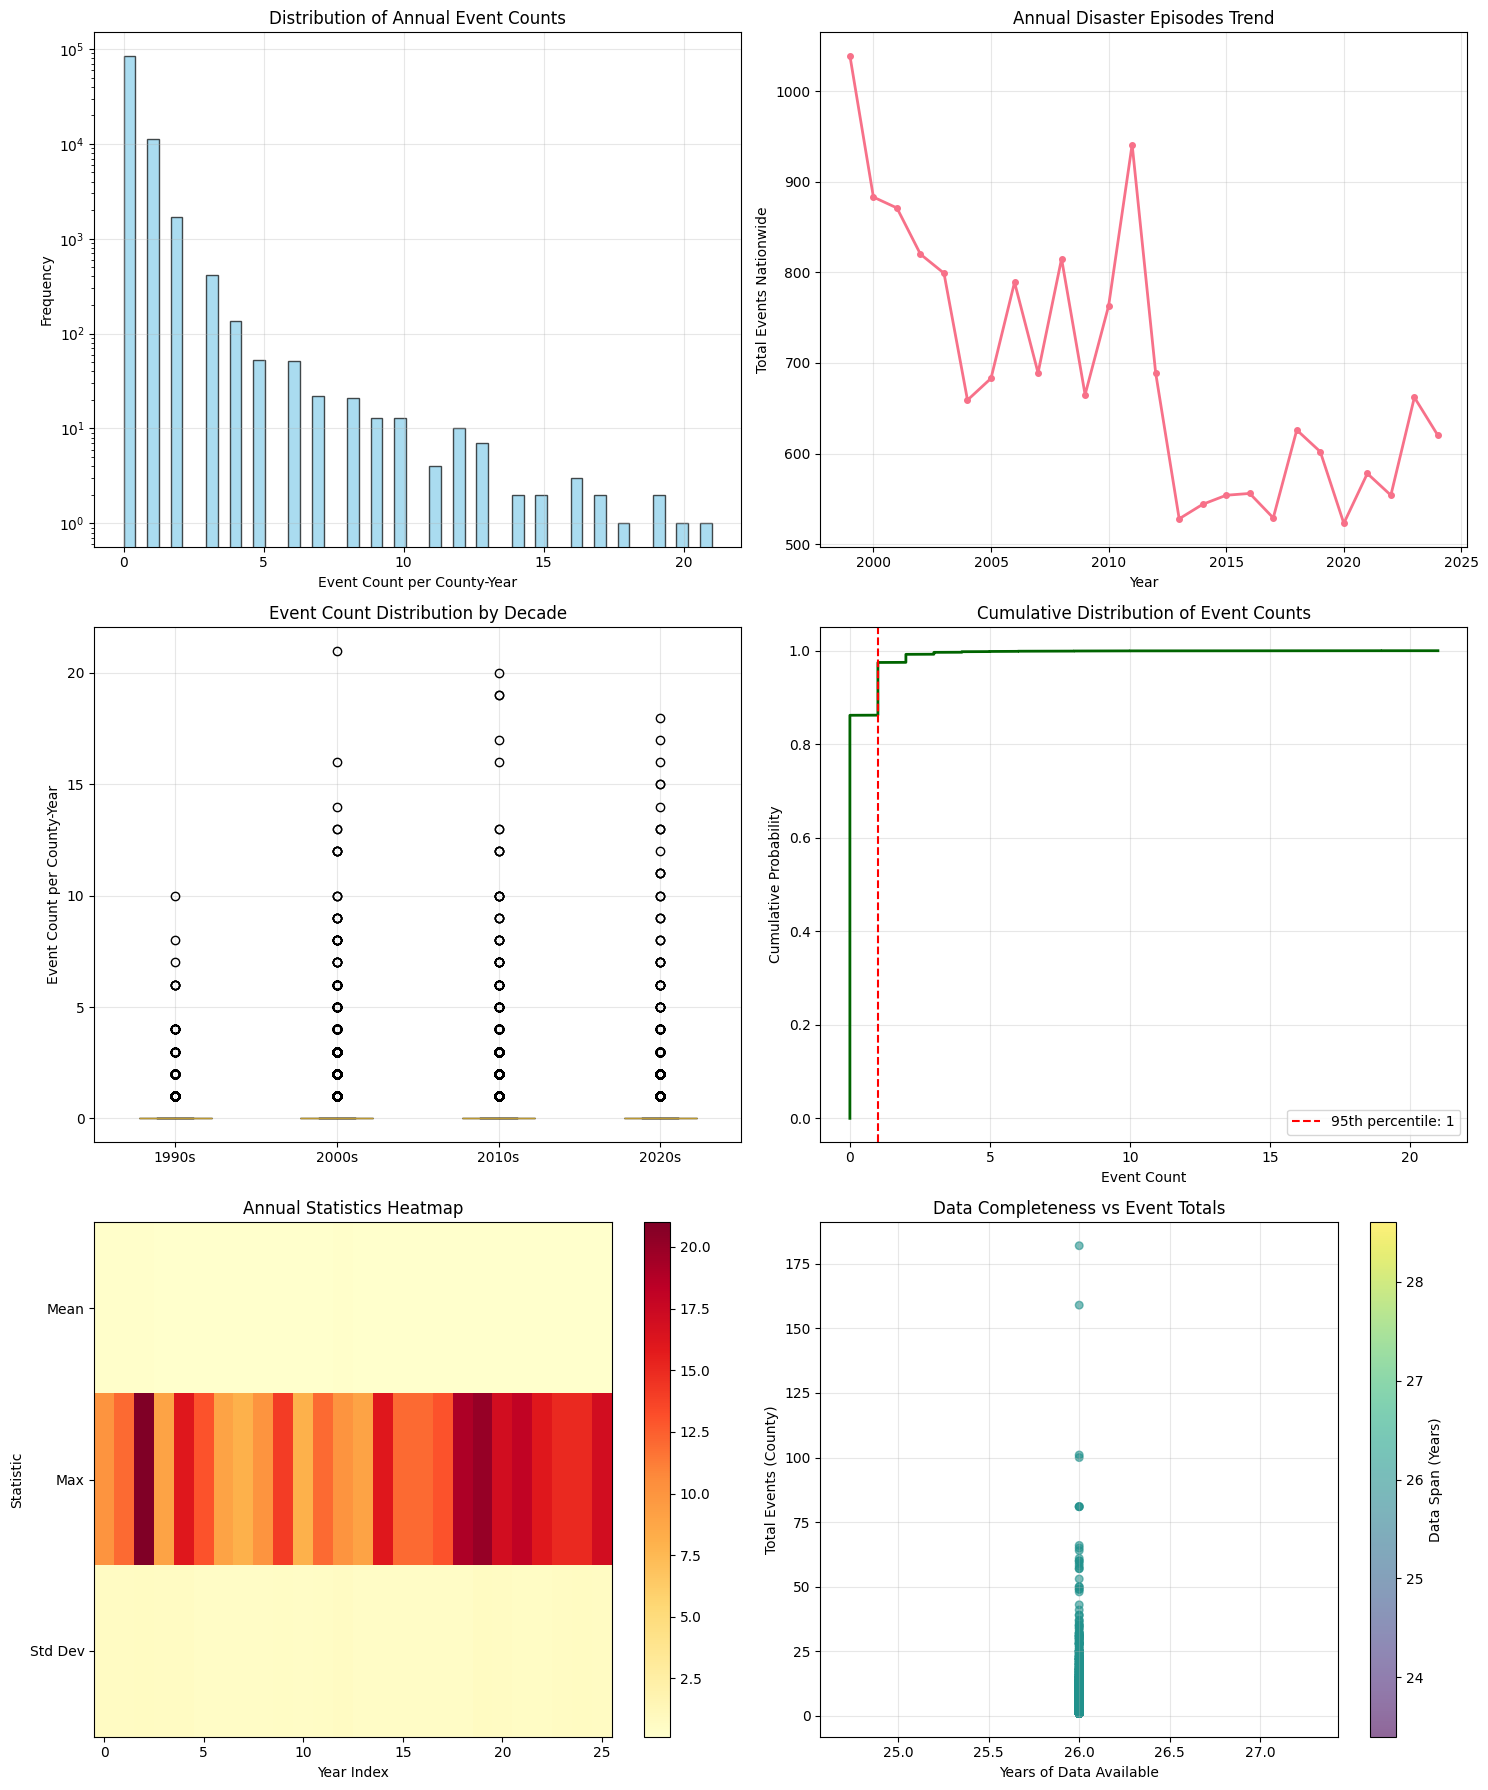

In [7]:


# Set style for better looking plots
plt.style.use('default')
sns.set_palette("husl")

# Create a comprehensive multi-panel visualization
fig, axes = plt.subplots(3, 2, figsize=(15, 18))

# 1. Event count distribution (histogram with log scale)
axes[0,0].hist(df_noaa['event_count'], bins=50, alpha=0.7, edgecolor='black', color='skyblue')
axes[0,0].set_xlabel('Event Count per County-Year')
axes[0,0].set_ylabel('Frequency')
axes[0,0].set_title('Distribution of Annual Event Counts')
axes[0,0].set_yscale('log')
axes[0,0].grid(alpha=0.3)

# 2. Time series of total events per year
yearly_totals = df_noaa.groupby('year')['event_count'].sum()
axes[0,1].plot(yearly_totals.index, yearly_totals.values, marker='o', linewidth=2, markersize=4)
axes[0,1].set_xlabel('Year')
axes[0,1].set_ylabel('Total Events Nationwide')
axes[0,1].set_title('Annual Disaster Episodes Trend')
axes[0,1].grid(alpha=0.3)

# 3. Box plot of event counts by decade
df_noaa['decade'] = (df_noaa['year'] // 10) * 10
decade_data = [df_noaa[df_noaa['decade'] == d]['event_count'] for d in sorted(df_noaa['decade'].unique())]
decade_labels = [f"{int(d)}s" for d in sorted(df_noaa['decade'].unique())]
bp1 = axes[1,0].boxplot(decade_data, labels=decade_labels, patch_artist=True)
axes[1,0].set_ylabel('Event Count per County-Year')
axes[1,0].set_title('Event Count Distribution by Decade')
axes[1,0].grid(alpha=0.3)
for patch in bp1['boxes']:
    patch.set_facecolor('lightcoral')

# 4. Cumulative distribution of event counts
sorted_counts = np.sort(df_noaa['event_count'])
cumulative_prob = np.arange(1, len(sorted_counts) + 1) / len(sorted_counts)
axes[1,1].plot(sorted_counts, cumulative_prob, linewidth=2, color='darkgreen')
axes[1,1].set_xlabel('Event Count')
axes[1,1].set_ylabel('Cumulative Probability')
axes[1,1].set_title('Cumulative Distribution of Event Counts')
axes[1,1].grid(alpha=0.3)
axes[1,1].axvline(x=sorted_counts[int(0.95*len(sorted_counts))], color='red', linestyle='--', 
                  label=f'95th percentile: {sorted_counts[int(0.95*len(sorted_counts))]:.0f}')
axes[1,1].legend()

# 5. Heatmap of annual statistics
yearly_stats = df_noaa.groupby('year')['event_count'].agg(['mean', 'max', 'std']).fillna(0)
im = axes[2,0].imshow([yearly_stats['mean'].values, yearly_stats['max'].values, yearly_stats['std'].values], 
                      aspect='auto', cmap='YlOrRd')
axes[2,0].set_xlabel('Year Index')
axes[2,0].set_ylabel('Statistic')
axes[2,0].set_title('Annual Statistics Heatmap')
axes[2,0].set_yticks([0, 1, 2])
axes[2,0].set_yticklabels(['Mean', 'Max', 'Std Dev'])
plt.colorbar(im, ax=axes[2,0])

# 6. Scatter plot: Total events vs years of data for each county
county_summary = df_noaa.groupby('county_fips').agg({
    'event_count': ['sum', 'count'],
    'year': ['min', 'max']
})
county_summary.columns = ['total_events', 'years_observed', 'first_year', 'last_year']
county_summary['data_span'] = county_summary['last_year'] - county_summary['first_year'] + 1

scatter = axes[2,1].scatter(county_summary['years_observed'], county_summary['total_events'], 
                           alpha=0.6, s=30, c=county_summary['data_span'], cmap='viridis')
axes[2,1].set_xlabel('Years of Data Available')
axes[2,1].set_ylabel('Total Events (County)')
axes[2,1].set_title('Data Completeness vs Event Totals')
axes[2,1].grid(alpha=0.3)
plt.colorbar(scatter, ax=axes[2,1], label='Data Span (Years)')

plt.tight_layout()
plt.show()

In [ ]:
# Calculate lambda (average annual event rate) for each county - UPDATED with corrected data

county_lambdas = df_noaa.groupby('county_fips').agg({
    'event_count': ['mean', 'var', 'std', 'count', 'sum'],
    'year': ['min', 'max']
}).round(4)

# Flatten column names
county_lambdas.columns = ['_'.join(col).strip() for col in county_lambdas.columns]
county_lambdas = county_lambdas.reset_index()

# Rename for clarity
county_lambdas.rename(columns={
    'event_count_mean': 'lambda_hat',
    'event_count_var': 'variance', 
    'event_count_std': 'std_dev',
    'event_count_count': 'years_observed',
    'event_count_sum': 'total_events',
    'year_min': 'first_year',
    'year_max': 'last_year'
}, inplace=True)

# Calculate overdispersion ratio (variance/mean)
# Handle division by zero for counties with lambda = 0
county_lambdas['overdispersion_ratio'] = np.where(
    county_lambdas['lambda_hat'] > 0,
    county_lambdas['variance'] / county_lambdas['lambda_hat'],
    np.nan
)

print(f"Lambda estimates calculated for {len(county_lambdas)} counties")
print("\nCounty-level Poisson parameters (sample):")
display(county_lambdas.head(10))

print(f"\n=== LAMBDA DISTRIBUTION SUMMARY ===")
print(f"Mean lambda: {county_lambdas['lambda_hat'].mean():.3f}")
print(f"Median lambda: {county_lambdas['lambda_hat'].median():.3f}")
print(f"Standard deviation: {county_lambdas['lambda_hat'].std():.3f}")
print(f"Min lambda: {county_lambdas['lambda_hat'].min():.3f}")
print(f"Max lambda: {county_lambdas['lambda_hat'].max():.3f}")

# Count counties by lambda ranges
print(f"\n=== LAMBDA RANGE DISTRIBUTION ===")
print(f"λ = 0 (no events): {(county_lambdas['lambda_hat'] == 0).sum()}")
print(f"0 < λ ≤ 0.5: {((county_lambdas['lambda_hat'] > 0) & (county_lambdas['lambda_hat'] <= 0.5)).sum()}")
print(f"0.5 < λ ≤ 1: {((county_lambdas['lambda_hat'] > 0.5) & (county_lambdas['lambda_hat'] <= 1)).sum()}")
print(f"1 < λ ≤ 2: {((county_lambdas['lambda_hat'] > 1) & (county_lambdas['lambda_hat'] <= 2)).sum()}")
print(f"2 < λ ≤ 5: {((county_lambdas['lambda_hat'] > 2) & (county_lambdas['lambda_hat'] <= 5)).sum()}")
print(f"λ > 5: {(county_lambdas['lambda_hat'] > 5).sum()}")

# Overdispersion analysis
valid_overdispersion = county_lambdas[county_lambdas['lambda_hat'] > 0]['overdispersion_ratio']
print(f"\n=== OVERDISPERSION ANALYSIS (counties with λ > 0) ===")
print(f"Counties with λ > 0: {len(valid_overdispersion)}")
print(f"Mean variance/mean ratio: {valid_overdispersion.mean():.3f}")
print(f"Counties with overdispersion (var/mean > 1.5): {(valid_overdispersion > 1.5).sum()}")
print(f"Percentage overdispersed: {(valid_overdispersion > 1.5).sum() / len(valid_overdispersion) * 100:.1f}%")

=== CALCULATING LAMBDA ESTIMATES WITH CORRECTED DATA ===
Lambda estimates calculated for 3788 counties

County-level Poisson parameters (sample):


,county_fips,lambda_hat,variance,std_dev,years_observed,total_events,first_year,last_year,overdispersion_ratio
0,01001,0.5000,0.4200,0.6481,26,13,1999,2024,0.840000
1,01002,0.1538,0.1354,0.3679,26,4,1999,2024,0.880364
2,01003,1.1538,1.1754,1.0842,26,30,1999,2024,1.018721
3,01004,0.0769,0.0738,0.2717,26,2,1999,2024,0.959688
4,01005,0.2308,0.1846,0.4297,26,6,1999,2024,0.799827
5,01006,0.4231,0.6538,0.8086,26,11,1999,2024,1.545261
6,01007,0.3846,0.4062,0.6373,26,10,1999,2024,1.056162
7,01008,0.1538,0.1354,0.3679,26,4,1999,2024,0.880364
8,01009,0.4231,0.3338,0.5778,26,11,1999,2024,0.788939
9,01010,0.0385,0.0385,0.1961,26,1,1999,2024,1.000000



=== LAMBDA DISTRIBUTION SUMMARY ===
Mean lambda: 0.183
Median lambda: 0.115
Standard deviation: 0.298
Min lambda: 0.038
Max lambda: 7.000

=== LAMBDA RANGE DISTRIBUTION ===
λ = 0 (no events): 0
0 < λ ≤ 0.5: 3577
0.5 < λ ≤ 1: 148
1 < λ ≤ 2: 45
2 < λ ≤ 5: 16
λ > 5: 2

=== OVERDISPERSION ANALYSIS (counties with λ > 0) ===
Counties with λ > 0: 3788
Mean variance/mean ratio: 1.102
Counties with overdispersion (var/mean > 1.5): 337
Percentage overdispersed: 8.9%


## BREAK, delete this cell

next steps
Severity modeling using census resilience data
Compound model integration (frequency × severity)
Risk scenario simulation
Geographic risk mapping

In [ ]:
# Calculate lambda (average annual event rate) for each county
county_lambdas = df_noaa.groupby('county_fips').agg({
    'event_count': ['mean', 'var', 'std', 'count', 'sum'],
    'year': ['min', 'max']
}).round(4)

# Flatten column names
county_lambdas.columns = ['_'.join(col).strip() for col in county_lambdas.columns]
county_lambdas = county_lambdas.reset_index()

# Rename for clarity
county_lambdas.rename(columns={
    'event_count_mean': 'lambda_hat',
    'event_count_var': 'variance', 
    'event_count_std': 'std_dev',
    'event_count_count': 'years_observed',
    'event_count_sum': 'total_events',
    'year_min': 'first_year',
    'year_max': 'last_year'
}, inplace=True)

# Calculate overdispersion ratio (variance/mean)
county_lambdas['overdispersion_ratio'] = county_lambdas['variance'] / county_lambdas['lambda_hat']

print("County-level Poisson parameters:")
display(county_lambdas.head(10))

County-level Poisson parameters:


,county_fips,lambda_hat,variance,std_dev,years_observed,total_events,first_year,last_year,overdispersion_ratio
0,01001,0.5000,0.4200,0.6481,26,13,1999,2024,0.840000
1,01002,0.1538,0.1354,0.3679,26,4,1999,2024,0.880364
2,01003,1.1538,1.1754,1.0842,26,30,1999,2024,1.018721
3,01004,0.0769,0.0738,0.2717,26,2,1999,2024,0.959688
4,01005,0.2308,0.1846,0.4297,26,6,1999,2024,0.799827
5,01006,0.4231,0.6538,0.8086,26,11,1999,2024,1.545261
6,01007,0.3846,0.4062,0.6373,26,10,1999,2024,1.056162
7,01008,0.1538,0.1354,0.3679,26,4,1999,2024,0.880364
8,01009,0.4231,0.3338,0.5778,26,11,1999,2024,0.788939
9,01010,0.0385,0.0385,0.1961,26,1,1999,2024,1.000000


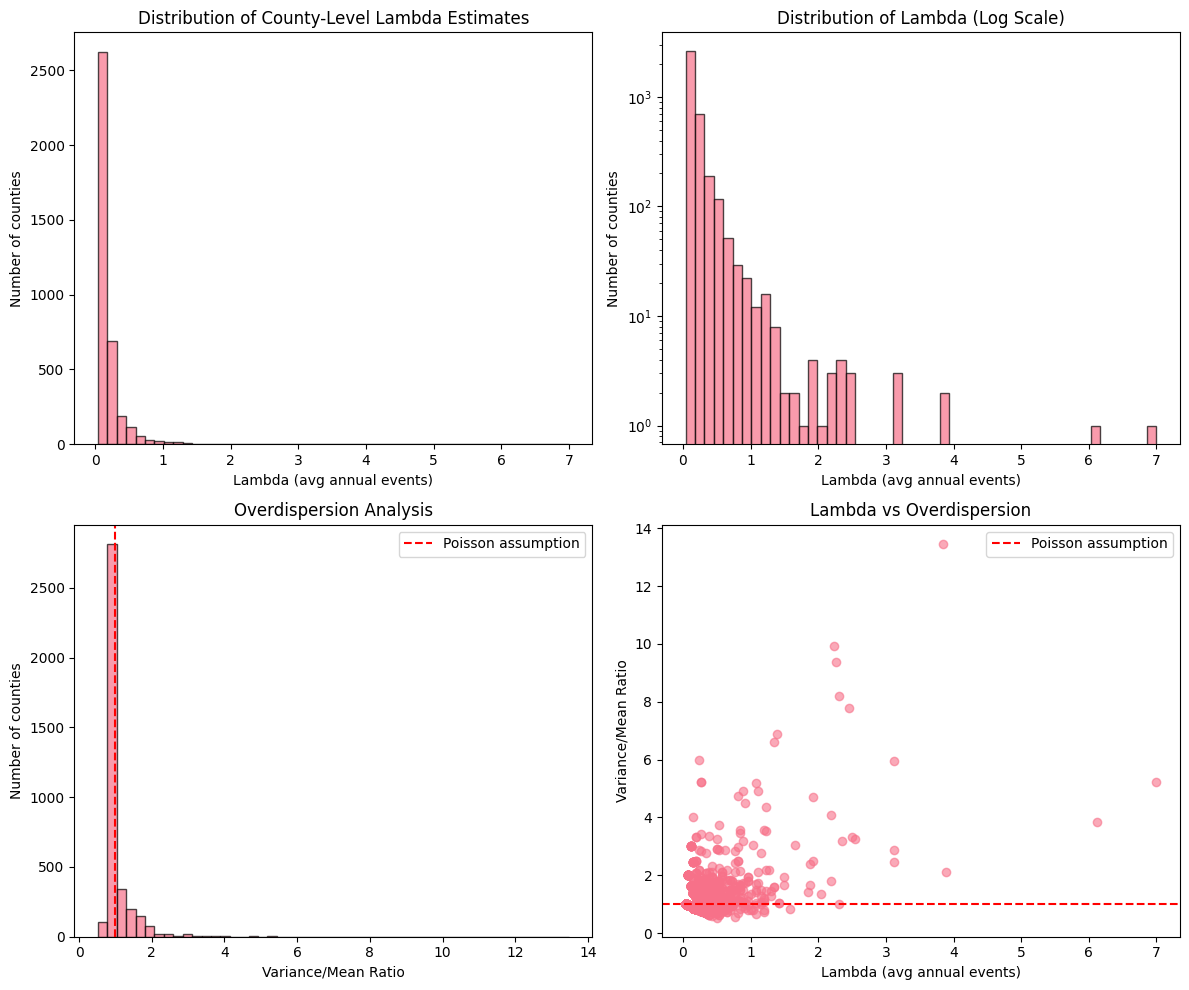

In [ ]:
# Visualize the distribution of lambda estimates
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Histogram of lambda estimates
axes[0,0].hist(county_lambdas['lambda_hat'], bins=50, alpha=0.7, edgecolor='black')
axes[0,0].set_xlabel('Lambda (avg annual events)')
axes[0,0].set_ylabel('Number of counties')
axes[0,0].set_title('Distribution of County-Level Lambda Estimates')

# Log-scale histogram for better visibility
axes[0,1].hist(county_lambdas['lambda_hat'], bins=50, alpha=0.7, edgecolor='black')
axes[0,1].set_xlabel('Lambda (avg annual events)')
axes[0,1].set_ylabel('Number of counties')
axes[0,1].set_yscale('log')
axes[0,1].set_title('Distribution of Lambda (Log Scale)')

# Overdispersion ratio
axes[1,0].hist(county_lambdas['overdispersion_ratio'], bins=50, alpha=0.7, edgecolor='black')
axes[1,0].set_xlabel('Variance/Mean Ratio')
axes[1,0].set_ylabel('Number of counties')
axes[1,0].set_title('Overdispersion Analysis')
axes[1,0].axvline(x=1, color='red', linestyle='--', label='Poisson assumption')
axes[1,0].legend()

# Scatter: lambda vs overdispersion
axes[1,1].scatter(county_lambdas['lambda_hat'], county_lambdas['overdispersion_ratio'], alpha=0.6)
axes[1,1].set_xlabel('Lambda (avg annual events)')
axes[1,1].set_ylabel('Variance/Mean Ratio')
axes[1,1].set_title('Lambda vs Overdispersion')
axes[1,1].axhline(y=1, color='red', linestyle='--', label='Poisson assumption')
axes[1,1].legend()

plt.tight_layout()
plt.show()

In [ ]:
# Summary statistics for lambda estimates
print("Summary of lambda estimates across all counties:")
print(county_lambdas['lambda_hat'].describe())

print(f"\nData completeness:")
print(f"Total counties: {len(county_lambdas)}")
print(f"Counties with ≥10 years data: {(county_lambdas['years_observed'] >= 10).sum()}")
print(f"Counties with ≥20 years data: {(county_lambdas['years_observed'] >= 20).sum()}")
print(f"Mean years observed: {county_lambdas['years_observed'].mean():.1f}")

Summary of lambda estimates across all counties:
count    3788.000000
mean        0.182576
std         0.297967
min         0.038500
25%         0.038500
50%         0.115400
75%         0.192300
max         7.000000
Name: lambda_hat, dtype: float64

Data completeness:
Total counties: 3788
Counties with ≥10 years data: 3788
Counties with ≥20 years data: 3788
Mean years observed: 26.0


In [ ]:
# Create final Poisson risk parameters table for modeling
poisson_risk_params = county_lambdas[['county_fips', 'lambda_hat', 'years_observed', 'total_events']].copy()

# Add confidence intervals for lambda estimates (assuming Poisson MLE)
# For Poisson MLE, CI is approximately: λ ± 1.96 * sqrt(λ/n)
poisson_risk_params['lambda_se'] = np.sqrt(poisson_risk_params['lambda_hat'] / poisson_risk_params['years_observed'])
poisson_risk_params['lambda_ci_lower'] = poisson_risk_params['lambda_hat'] - 1.96 * poisson_risk_params['lambda_se']
poisson_risk_params['lambda_ci_upper'] = poisson_risk_params['lambda_hat'] + 1.96 * poisson_risk_params['lambda_se']

# Ensure lower bound is non-negative
poisson_risk_params['lambda_ci_lower'] = np.maximum(0, poisson_risk_params['lambda_ci_lower'])

print("Poisson Risk Parameters (sample):")
display(poisson_risk_params.head(10))

Poisson Risk Parameters (sample):


,county_fips,lambda_hat,years_observed,total_events,lambda_se,lambda_ci_lower,lambda_ci_upper
0,01001,0.5000,26,13,0.138675,0.228197,0.771803
1,01002,0.1538,26,4,0.076912,0.003053,0.304547
2,01003,1.1538,26,30,0.210658,0.740910,1.566690
3,01004,0.0769,26,2,0.054385,0.000000,0.183494
4,01005,0.2308,26,6,0.094217,0.046134,0.415466
5,01006,0.4231,26,11,0.127566,0.173071,0.673129
6,01007,0.3846,26,10,0.121624,0.146218,0.622982
7,01008,0.1538,26,4,0.076912,0.003053,0.304547
8,01009,0.4231,26,11,0.127566,0.173071,0.673129
9,01010,0.0385,26,1,0.038481,0.000000,0.113922


In [ ]:
# Risk classification based on lambda estimates
def classify_risk_level(lambda_val):
    if lambda_val < 0.5:
        return 'Very Low'
    elif lambda_val < 2:
        return 'Low' 
    elif lambda_val < 5:
        return 'Moderate'
    elif lambda_val < 10:
        return 'High'
    else:
        return 'Very High'

poisson_risk_params['risk_category'] = poisson_risk_params['lambda_hat'].apply(classify_risk_level)

print("Risk category distribution:")
print(poisson_risk_params['risk_category'].value_counts().sort_index())

Risk category distribution:
risk_category
High           2
Low          235
Moderate      16
Very Low    3535
Name: count, dtype: int64


In [ ]:
# Save the Poisson parameters to database for use in compound model
dbt.load_data(poisson_risk_params, "POISSON_FREQUENCY_PARAMS", if_exists="replace")
print("Poisson frequency parameters saved to database as POISSON_FREQUENCY_PARAMS")


Created SQLAlchemy engine for disaster_db
Data loaded successfully into POISSON_FREQUENCY_PARAMS
Poisson frequency parameters saved to database as POISSON_FREQUENCY_PARAMS


In [ ]:
# Check what NRI tables are available
nri_tables = dbt.query("""
    SELECT table_name 
    FROM information_schema.tables 
    WHERE table_schema='public' 
    AND table_name LIKE '%nri%'
""")
print("Available NRI tables:")
display(nri_tables)

Created SQLAlchemy engine for disaster_db
Error executing query: sqlalchemy.cyextension.immutabledict.immutabledict is not a sequence
Available NRI tables:


""


In [ ]:
# Check if we can use census_resilience table for county mapping (it should have FIPS)
try:
    census_fips_check = dbt.query("""
        SELECT column_name 
        FROM information_schema.columns 
        WHERE table_name='census_resilience'
        AND (column_name LIKE '%fips%' OR column_name LIKE '%geoid%')
    """)
    print("\nFIPS/GEOID columns in census_resilience:")
    display(census_fips_check)
    
    # Sample the data to see FIPS format
    census_sample = dbt.query("SELECT * FROM census_resilience LIMIT 5")
    print("\nSample census_resilience data:")
    display(census_sample.head())
    
except Exception as e:
    print(f"Error checking census_resilience: {e}")

Created SQLAlchemy engine for disaster_db
Error executing query: sqlalchemy.cyextension.immutabledict.immutabledict is not a sequence

FIPS/GEOID columns in census_resilience:


""


Created SQLAlchemy engine for disaster_db

Sample census_resilience data:


,POPUNI,PRED0_E,PRED0_M,PRED0_PE,PRED0_PM,PRED12_E,PRED12_M,PRED12_PE,PRED12_PM,PRED3_E,PRED3_M,PRED3_PE,PRED3_PM,FIPS,COUNTY_FIPS,VULNERABILITY_RATE,RESILIENCE_RATE,VULNERABILITY_SCORE,POPULATION
0,1815,560,228,30.85,12.56,871,239,47.99,13.17,384,205,21.16,11.29,01001020100,01001,21.16,30.85,1.35465,1815
1,2004,720,262,35.93,13.07,896,269,44.71,13.42,388,222,19.36,11.08,01001020200,01001,19.36,35.93,1.25145,2004
2,3313,817,404,24.66,12.19,1831,405,55.27,12.22,665,317,20.07,9.57,01001020300,01001,20.07,24.66,1.43115,3313
3,4343,1301,522,29.96,12.02,2274,523,52.36,12.04,768,407,17.68,9.37,01001020400,01001,17.68,29.96,1.31580,4343
4,4442,1979,515,44.55,11.59,1670,515,37.60,11.59,793,392,17.85,8.82,01001020501,01001,17.85,44.55,1.09950,4442


In [ ]:
# Create state-level risk mapping without geographic boundaries
# Extract state FIPS from county FIPS (first 2 digits)
poisson_risk_params['state_fips'] = poisson_risk_params['county_fips'].str[:2]

# State FIPS to state name mapping (major states)
state_fips_map = {
    '01': 'Alabama', '02': 'Alaska', '04': 'Arizona', '05': 'Arkansas', '06': 'California',
    '08': 'Colorado', '09': 'Connecticut', '10': 'Delaware', '11': 'DC', '12': 'Florida',
    '13': 'Georgia', '15': 'Hawaii', '16': 'Idaho', '17': 'Illinois', '18': 'Indiana',
    '19': 'Iowa', '20': 'Kansas', '21': 'Kentucky', '22': 'Louisiana', '23': 'Maine',
    '24': 'Maryland', '25': 'Massachusetts', '26': 'Michigan', '27': 'Minnesota', '28': 'Mississippi',
    '29': 'Missouri', '30': 'Montana', '31': 'Nebraska', '32': 'Nevada', '33': 'New Hampshire',
    '34': 'New Jersey', '35': 'New Mexico', '36': 'New York', '37': 'North Carolina', '38': 'North Dakota',
    '39': 'Ohio', '40': 'Oklahoma', '41': 'Oregon', '42': 'Pennsylvania', '44': 'Rhode Island',
    '45': 'South Carolina', '46': 'South Dakota', '47': 'Tennessee', '48': 'Texas', '49': 'Utah',
    '50': 'Vermont', '51': 'Virginia', '53': 'Washington', '54': 'West Virginia', '55': 'Wisconsin', '56': 'Wyoming'
}

poisson_risk_params['state_name'] = poisson_risk_params['state_fips'].map(state_fips_map)

In [ ]:
# Aggregate risk statistics by state
state_risk_summary = poisson_risk_params.groupby(['state_fips', 'state_name']).agg({
    'lambda_hat': ['count', 'mean', 'median', 'max', 'std'],
    'total_events': 'sum',
    'risk_category': lambda x: x.value_counts().to_dict()
}).round(3)

# Flatten column names
state_risk_summary.columns = ['_'.join(col).strip() for col in state_risk_summary.columns]
state_risk_summary = state_risk_summary.reset_index()

# Rename for clarity
state_risk_summary.rename(columns={
    'lambda_hat_count': 'counties_count',
    'lambda_hat_mean': 'avg_lambda',
    'lambda_hat_median': 'median_lambda', 
    'lambda_hat_max': 'max_lambda',
    'lambda_hat_std': 'lambda_std',
    'total_events_sum': 'state_total_events'
}, inplace=True)

print("State-level disaster risk summary:")
display(state_risk_summary.sort_values('avg_lambda', ascending=False).head(15))

State-level disaster risk summary:


,state_fips,state_name,counties_count,avg_lambda,median_lambda,max_lambda,lambda_std,state_total_events,risk_category_<lambda>
8,11,DC,1,0.962,0.962,0.962,NaN,25,{'Low': 1}
7,10,Delaware,5,0.631,0.577,0.962,0.286,82,"{'Low': 4, 'Very Low': 1}"
2,04,Arizona,59,0.524,0.154,3.846,0.750,804,"{'Very Low': 40, 'Low': 15, 'Moderate': 4}"
28,32,Nevada,21,0.496,0.077,7.000,1.511,271,"{'Very Low': 19, 'Low': 1, 'High': 1}"
9,12,Florida,117,0.458,0.231,3.115,0.582,1392,"{'Very Low': 87, 'Low': 25, 'Moderate': 5}"
30,34,New Jersey,40,0.403,0.308,1.154,0.304,419,"{'Very Low': 28, 'Low': 12}"
4,06,California,123,0.326,0.154,3.115,0.464,1042,"{'Very Low': 97, 'Low': 24, 'Moderate': 2}"
6,09,Connecticut,13,0.281,0.192,0.962,0.269,95,"{'Very Low': 11, 'Low': 2}"
0,01,Alabama,95,0.262,0.192,1.308,0.250,647,"{'Very Low': 81, 'Low': 14}"
20,24,Maryland,37,0.257,0.154,1.154,0.270,247,"{'Very Low': 32, 'Low': 5}"


C:\Users\alben\AppData\Local\Temp\ipykernel_6384\4166341406.py:26: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = axes[0,1].boxplot(state_lambda_data, labels=state_labels, patch_artist=True)


KeyError: "['Very High'] not in index"

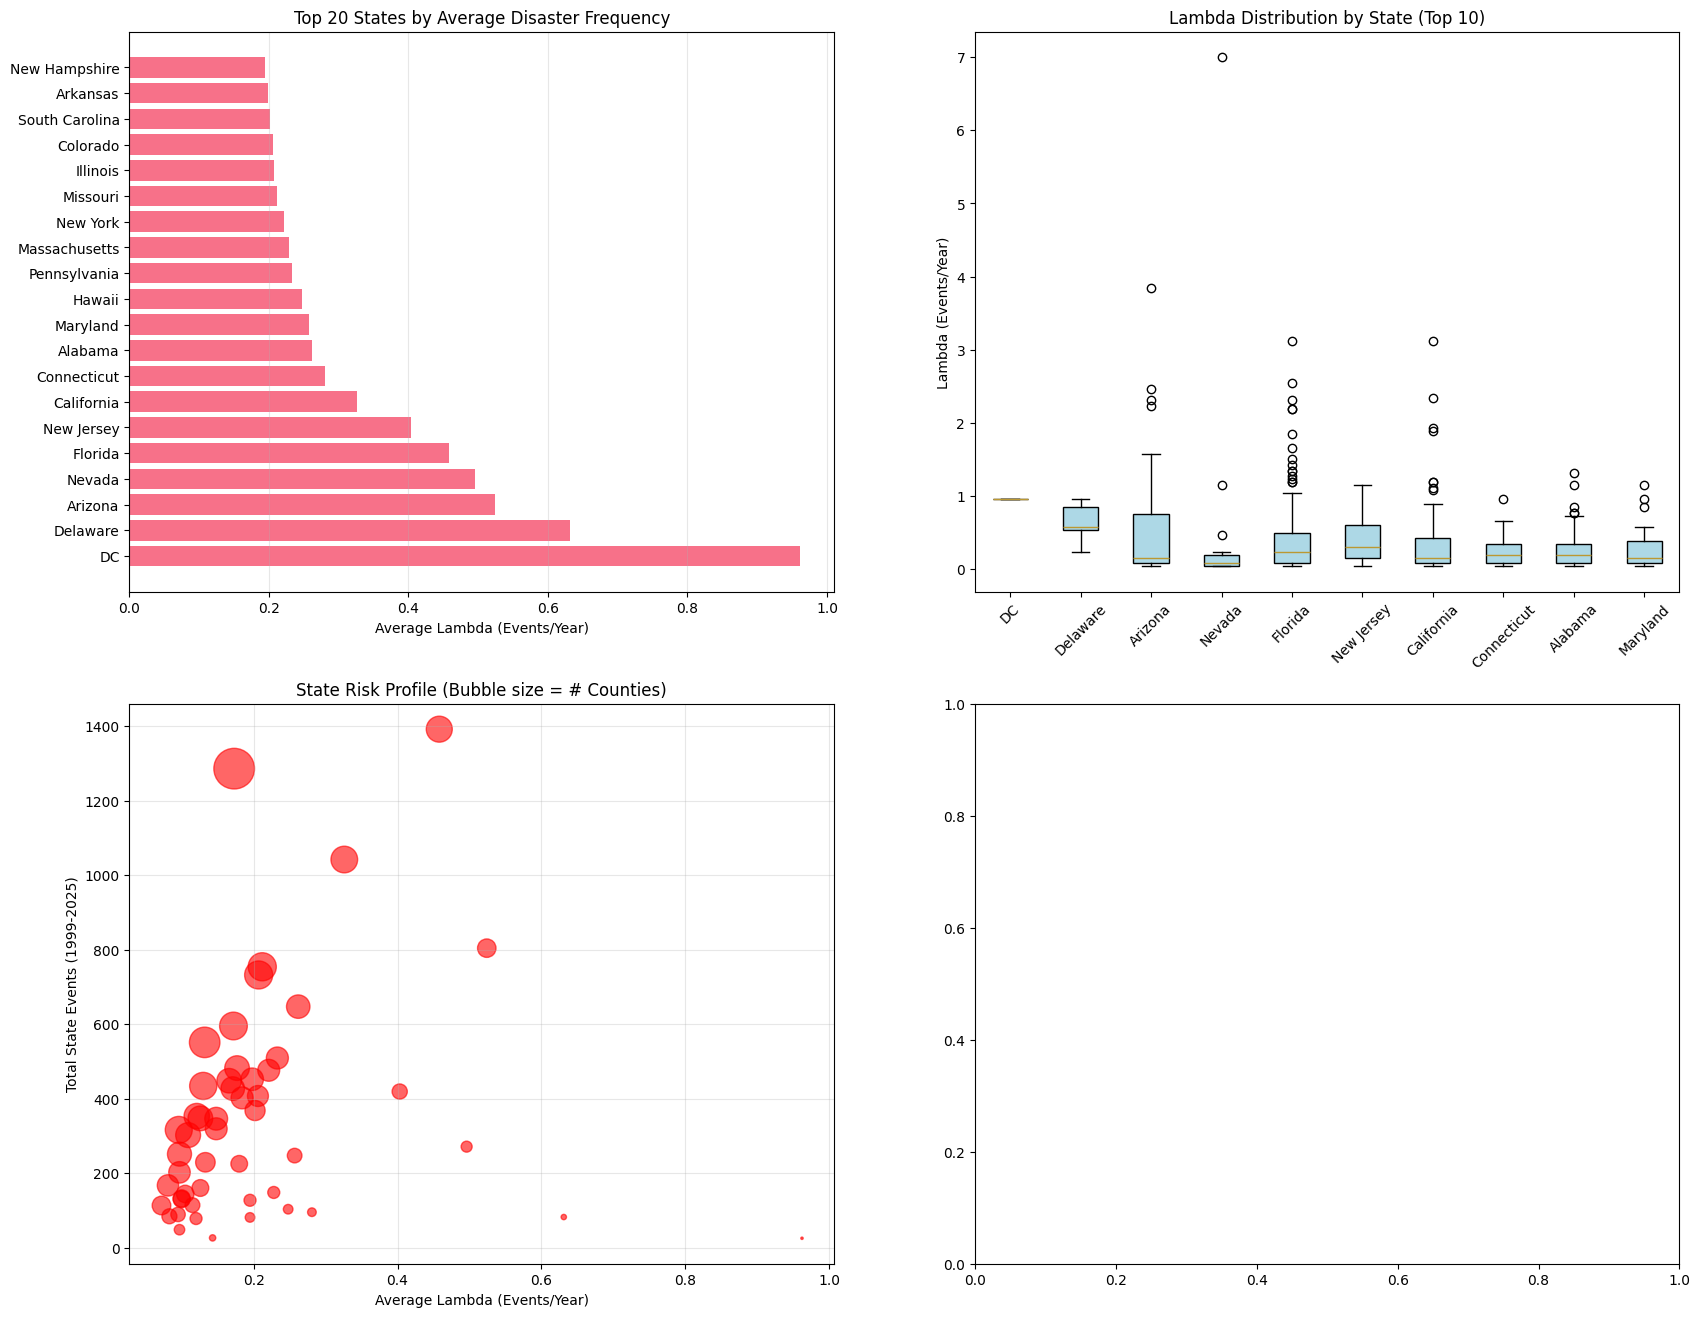

In [ ]:
# Create comprehensive risk visualization
fig, axes = plt.subplots(2, 2, figsize=(20, 16))

# 1. State-level average lambda (top 20 states)
top_states = state_risk_summary.nlargest(20, 'avg_lambda')
axes[0,0].barh(range(len(top_states)), top_states['avg_lambda'].values)
axes[0,0].set_yticks(range(len(top_states)))
axes[0,0].set_yticklabels(top_states['state_name'].values)
axes[0,0].set_xlabel('Average Lambda (Events/Year)')
axes[0,0].set_title('Top 20 States by Average Disaster Frequency')
axes[0,0].grid(axis='x', alpha=0.3)

# 2. Distribution of lambda by state (box plot for top 10 states)
top_10_states = state_risk_summary.nlargest(10, 'avg_lambda')['state_name'].tolist()
state_lambda_data = []
state_labels = []

for state in top_10_states:
    state_fips = state_risk_summary[state_risk_summary['state_name'] == state]['state_fips'].iloc[0]
    state_data = poisson_risk_params[poisson_risk_params['state_fips'] == state_fips]['lambda_hat'].values
    if len(state_data) > 0:
        state_lambda_data.append(state_data)
        state_labels.append(state)

if state_lambda_data:
    bp = axes[0,1].boxplot(state_lambda_data, labels=state_labels, patch_artist=True)
    axes[0,1].set_ylabel('Lambda (Events/Year)')
    axes[0,1].set_title('Lambda Distribution by State (Top 10)')
    axes[0,1].tick_params(axis='x', rotation=45)
    
    # Color the boxes
    for patch in bp['boxes']:
        patch.set_facecolor('lightblue')

# 3. State total events vs average lambda (scatter plot)
axes[1,0].scatter(state_risk_summary['avg_lambda'], state_risk_summary['state_total_events'], 
                  s=state_risk_summary['counties_count']*3, alpha=0.6, c='red')
axes[1,0].set_xlabel('Average Lambda (Events/Year)')
axes[1,0].set_ylabel('Total State Events (1999-2025)')
axes[1,0].set_title('State Risk Profile (Bubble size = # Counties)')
axes[1,0].grid(alpha=0.3)

# Add state labels for outliers
for idx, row in state_risk_summary.iterrows():
    if row['avg_lambda'] > 15 or row['state_total_events'] > 5000:
        axes[1,0].annotate(row['state_name'], 
                          (row['avg_lambda'], row['state_total_events']),
                          xytext=(5, 5), textcoords='offset points', fontsize=8)

# 4. Risk category distribution by region
risk_cats = ['Very Low', 'Low', 'Moderate', 'High', 'Very High']
risk_counts = poisson_risk_params['risk_category'].value_counts()[risk_cats]

axes[1,1].pie(risk_counts.values, labels=risk_cats, autopct='%1.1f%%', 
              colors=['#2166ac', '#92c5de', '#f7f7f7', '#f4a582', '#b2182b'])
axes[1,1].set_title('National Risk Category Distribution')

plt.tight_layout()
plt.show()

In [ ]:
# Detailed analysis of highest risk counties
print("=== HIGH RISK COUNTY ANALYSIS ===")
high_risk_counties = poisson_risk_params.nlargest(20, 'lambda_hat')
print(f"\nTop 20 Highest Risk Counties (λ > {high_risk_counties['lambda_hat'].iloc[19]:.1f}):")
display(high_risk_counties[['county_fips', 'state_name', 'lambda_hat', 'total_events', 'years_observed', 'risk_category']])

# Geographic patterns analysis
print(f"\n=== GEOGRAPHIC PATTERNS ===")
print(f"Counties with λ > 20: {(poisson_risk_params['lambda_hat'] > 20).sum()}")
print(f"Counties with λ > 15: {(poisson_risk_params['lambda_hat'] > 15).sum()}")
print(f"Counties with λ > 10: {(poisson_risk_params['lambda_hat'] > 10).sum()}")

# State with most high-risk counties
very_high_risk = poisson_risk_params[poisson_risk_params['risk_category'] == 'Very High']
state_high_risk_counts = very_high_risk['state_name'].value_counts().head(10)
print(f"\nStates with most 'Very High' risk counties:")
for state, count in state_high_risk_counts.items():
    total_counties = (poisson_risk_params['state_name'] == state).sum()
    pct = (count / total_counties) * 100
    print(f"  {state}: {count} counties ({pct:.1f}% of state's counties)")

# Summary statistics
print(f"\n=== SUMMARY STATISTICS ===")
print(f"Total counties analyzed: {len(poisson_risk_params)}")
print(f"Mean lambda across all counties: {poisson_risk_params['lambda_hat'].mean():.2f}")
print(f"Median lambda: {poisson_risk_params['lambda_hat'].median():.2f}")
print(f"Standard deviation: {poisson_risk_params['lambda_hat'].std():.2f}")
print(f"Range: {poisson_risk_params['lambda_hat'].min():.2f} - {poisson_risk_params['lambda_hat'].max():.2f}")

# Validate risk thresholds against reality
print(f"\n=== RISK THRESHOLD VALIDATION ===")
print(f"Current thresholds may be reasonable for severe events (deaths/injuries)")
print(f"Remember: These are episodes with direct casualties, not all weather events")
print(f"High λ values reflect counties with frequent severe disasters requiring emergency response")

=== HIGH RISK COUNTY ANALYSIS ===

Top 20 Highest Risk Counties (λ > 57.3):


,county_fips,state_name,lambda_hat,total_events,years_observed,risk_category
760,08041,Colorado,82.0370,2215,27,Very High
1429,17031,Illinois,80.5926,2176,27,Very High
267,04013,Arizona,79.0000,2133,27,Very High
4195,42003,Pennsylvania,77.5926,2095,27,Very High
1984,20173,Kansas,77.0000,2079,27,Very High
4491,46103,South Dakota,71.0370,1918,27,Very High
644,06338,California,70.4000,352,5,Very High
543,06071,California,68.6667,1854,27,Very High
5022,48439,Texas,67.7778,1830,27,Very High
1823,19153,Iowa,67.6667,1827,27,Very High



=== GEOGRAPHIC PATTERNS ===
Counties with λ > 20: 746
Counties with λ > 15: 1381
Counties with λ > 10: 2420

States with most 'Very High' risk counties:
  Texas: 185 counties (45.0% of state's counties)
  Kansas: 102 counties (65.0% of state's counties)
  California: 101 counties (40.2% of state's counties)
  Missouri: 85 counties (49.4% of state's counties)
  Illinois: 85 counties (54.5% of state's counties)
  Iowa: 83 counties (56.1% of state's counties)
  Oklahoma: 81 counties (70.4% of state's counties)
  Virginia: 79 counties (37.8% of state's counties)
  New York: 78 counties (72.2% of state's counties)
  Nebraska: 74 counties (52.5% of state's counties)

=== SUMMARY STATISTICS ===
Total counties analyzed: 5728
Mean lambda across all counties: 11.01
Median lambda: 8.51
Standard deviation: 8.90
Range: 1.00 - 82.04

=== RISK THRESHOLD VALIDATION ===
Current thresholds may be reasonable for severe events (deaths/injuries)
Remember: These are episodes with direct casualties, not all